## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [2]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2
def build_l1_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_l1_l2_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio, l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [0.01, 0.001]
L2_EXP = [0.01, 0.001]


In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for regulizer_ratio_l1 in L1_EXP:    
    for regulizer_ratio_l2 in L2_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f, %.6f" % (regulizer_ratio_l1,regulizer_ratio_l2 ))
        model = build_l1_l2_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio_l1, l2_ratio=regulizer_ratio_l2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-l1_l2-l1:%s-l2:%s" % (str(regulizer_ratio_l1), str(regulizer_ratio_l2))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000, 0.010000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 8s 40ms/s

196/196 [==============================] - 6s 31ms/step - loss: 2.4614 - accuracy: 0.0973 - val_loss: 2.4614 - val_accuracy: 0.1000
Experiment with Regulizer = 0.010000, 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params:

196/196 [==============================] - 7s 34ms/step - loss: 2.4624 - accuracy: 0.0999 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 6s 32ms/step - loss: 2.4624 - accuracy: 0.0983 - val_loss: 2.4623 - val_accuracy: 0.1000
Experiment with Regulizer = 0.001000, 0.010000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________________

196/196 [==============================] - 7s 34ms/step - loss: 1.9821 - accuracy: 0.3348 - val_loss: 1.9853 - val_accuracy: 0.3325
Epoch 49/50
196/196 [==============================] - 7s 35ms/step - loss: 1.9810 - accuracy: 0.3368 - val_loss: 2.0093 - val_accuracy: 0.3187
Epoch 50/50
196/196 [==============================] - 7s 35ms/step - loss: 1.9800 - accuracy: 0.3371 - val_loss: 1.9824 - val_accuracy: 0.3311
Experiment with Regulizer = 0.001000, 0.001000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

196/196 [==============================] - 7s 34ms/step - loss: 1.8827 - accuracy: 0.3933 - val_loss: 1.8892 - val_accuracy: 0.3953
Epoch 47/50
196/196 [==============================] - 7s 35ms/step - loss: 1.8816 - accuracy: 0.3936 - val_loss: 1.8802 - val_accuracy: 0.3934
Epoch 48/50
196/196 [==============================] - 7s 34ms/step - loss: 1.8764 - accuracy: 0.3956 - val_loss: 1.8996 - val_accuracy: 0.3821
Epoch 49/50
196/196 [==============================] - 7s 34ms/step - loss: 1.8742 - accuracy: 0.3956 - val_loss: 1.8818 - val_accuracy: 0.3865
Epoch 50/50
196/196 [==============================] - 7s 34ms/step - loss: 1.8709 - accuracy: 0.3939 - val_loss: 1.8646 - val_accuracy: 0.3939


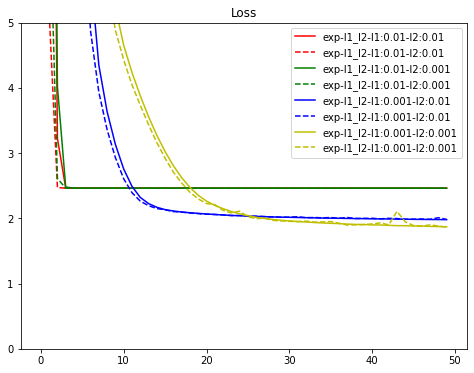

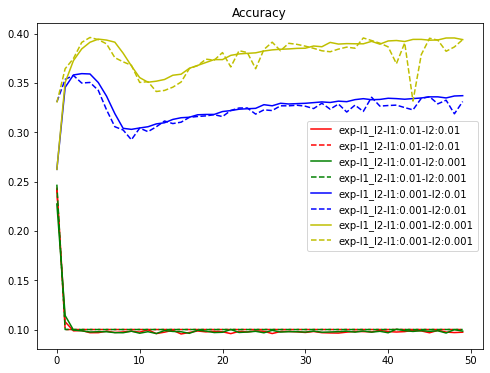

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()